In [862]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings

# Suppress warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Read In Data

In [863]:
# Reading in the training data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# remove id columns from both
test_ids = test_df['PassengerId']

# print the train_df head
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [864]:
# Isolate target 'Transported'
target = train_df['Transported']
train_df.drop(columns = ['Transported'], inplace = True)

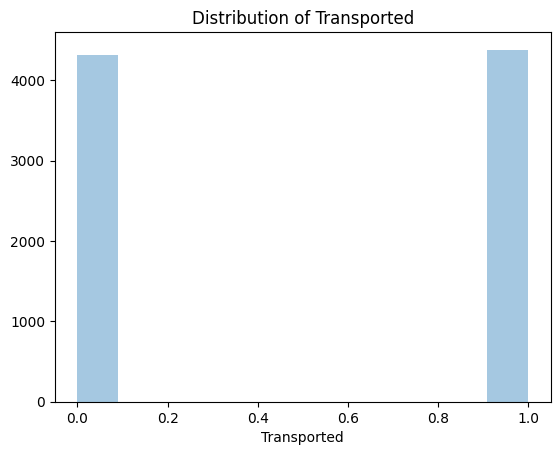

In [865]:
# plot hist
def plot_transported():
    fig, ax = plt.subplots()
    sns.distplot(target, ax=ax, kde=False)
    ax.set_title("Distribution of Transported")
    
# target
plot_transported()

# Concatonating Train and Test

In [866]:
# Joining each train and test counterpart df
def concat_dataframes(df_1, df_2):
    df_1_copy = df_1.copy()  # Work on a copy to avoid SettingWithCopyWarning
    df_2_copy = df_2.copy()  # Work on a copy to avoid SettingWithCopyWarning
    
    df_1_copy['From_df_1'] = True
    df_2_copy['From_df_1'] = False
    
    # Concatenate the dataframes
    return pd.concat([df_1_copy, df_2_copy], ignore_index=True)

In [867]:
# seperate train and test
def get_seperate_dataframes(concatenated_df):
    df_1 = concatenated_df[concatenated_df['From_df_1'] == True].drop(columns=['From_df_1'])
    df_2 = concatenated_df[concatenated_df['From_df_1'] == False].drop(columns=['From_df_1'])
    
    return df_1, df_2

In [868]:
# concat
all_df = concat_dataframes(train_df, test_df)

In [869]:
# convert bools to ints
bool_columns = all_df.select_dtypes(include=['bool']).columns
all_df[bool_columns] = all_df[bool_columns].astype(int)

# Preliminary Feature Engineering

In [870]:
# First, lets separate the data in the cabin column into it's respective pieces of data
cabin_split = all_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([all_df, cabin_split], axis=1)
all_df = new_df
all_df.drop(columns=['Cabin'], inplace=True)
all_df['Room_Number'] = all_df['Room_Number']

In [871]:
# Passenger ID into group ID
id_split = all_df['PassengerId'].str.split('_', expand=True)
id_split.columns = ['GroupId', "Index"]
new_df = pd.concat([all_df, id_split], axis=1)
all_df = new_df
all_df.drop(columns=['PassengerId', 'Index'], inplace=True)
all_df['GroupId'] = all_df['GroupId'].astype(int)

all_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,From_df_1,Deck,Room_Number,Side,GroupId
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,B,0,P,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0,S,2
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,1,A,0,S,3
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,1,A,0,S,3
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1,S,4


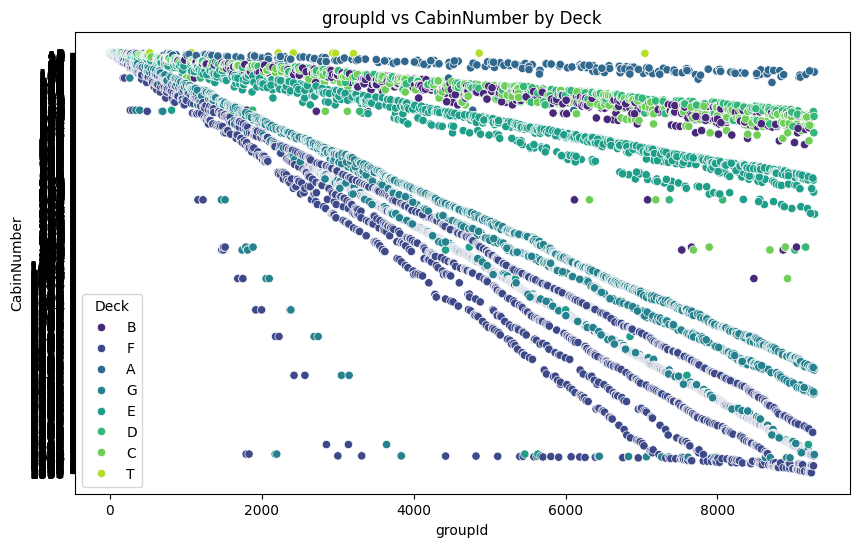

In [872]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
sns.scatterplot(data=all_df, x='GroupId', y='Room_Number', hue='Deck', palette='viridis', legend='full')

# Enhance the plot
plt.title('groupId vs CabinNumber by Deck')
plt.xlabel('groupId')
plt.ylabel('CabinNumber')
plt.legend(title='Deck')

plt.show()

# Eliminating Nans

In [873]:
# Initial missing values
all_df.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
From_df_1         0
Deck            299
Room_Number     299
Side            299
GroupId           0
dtype: int64

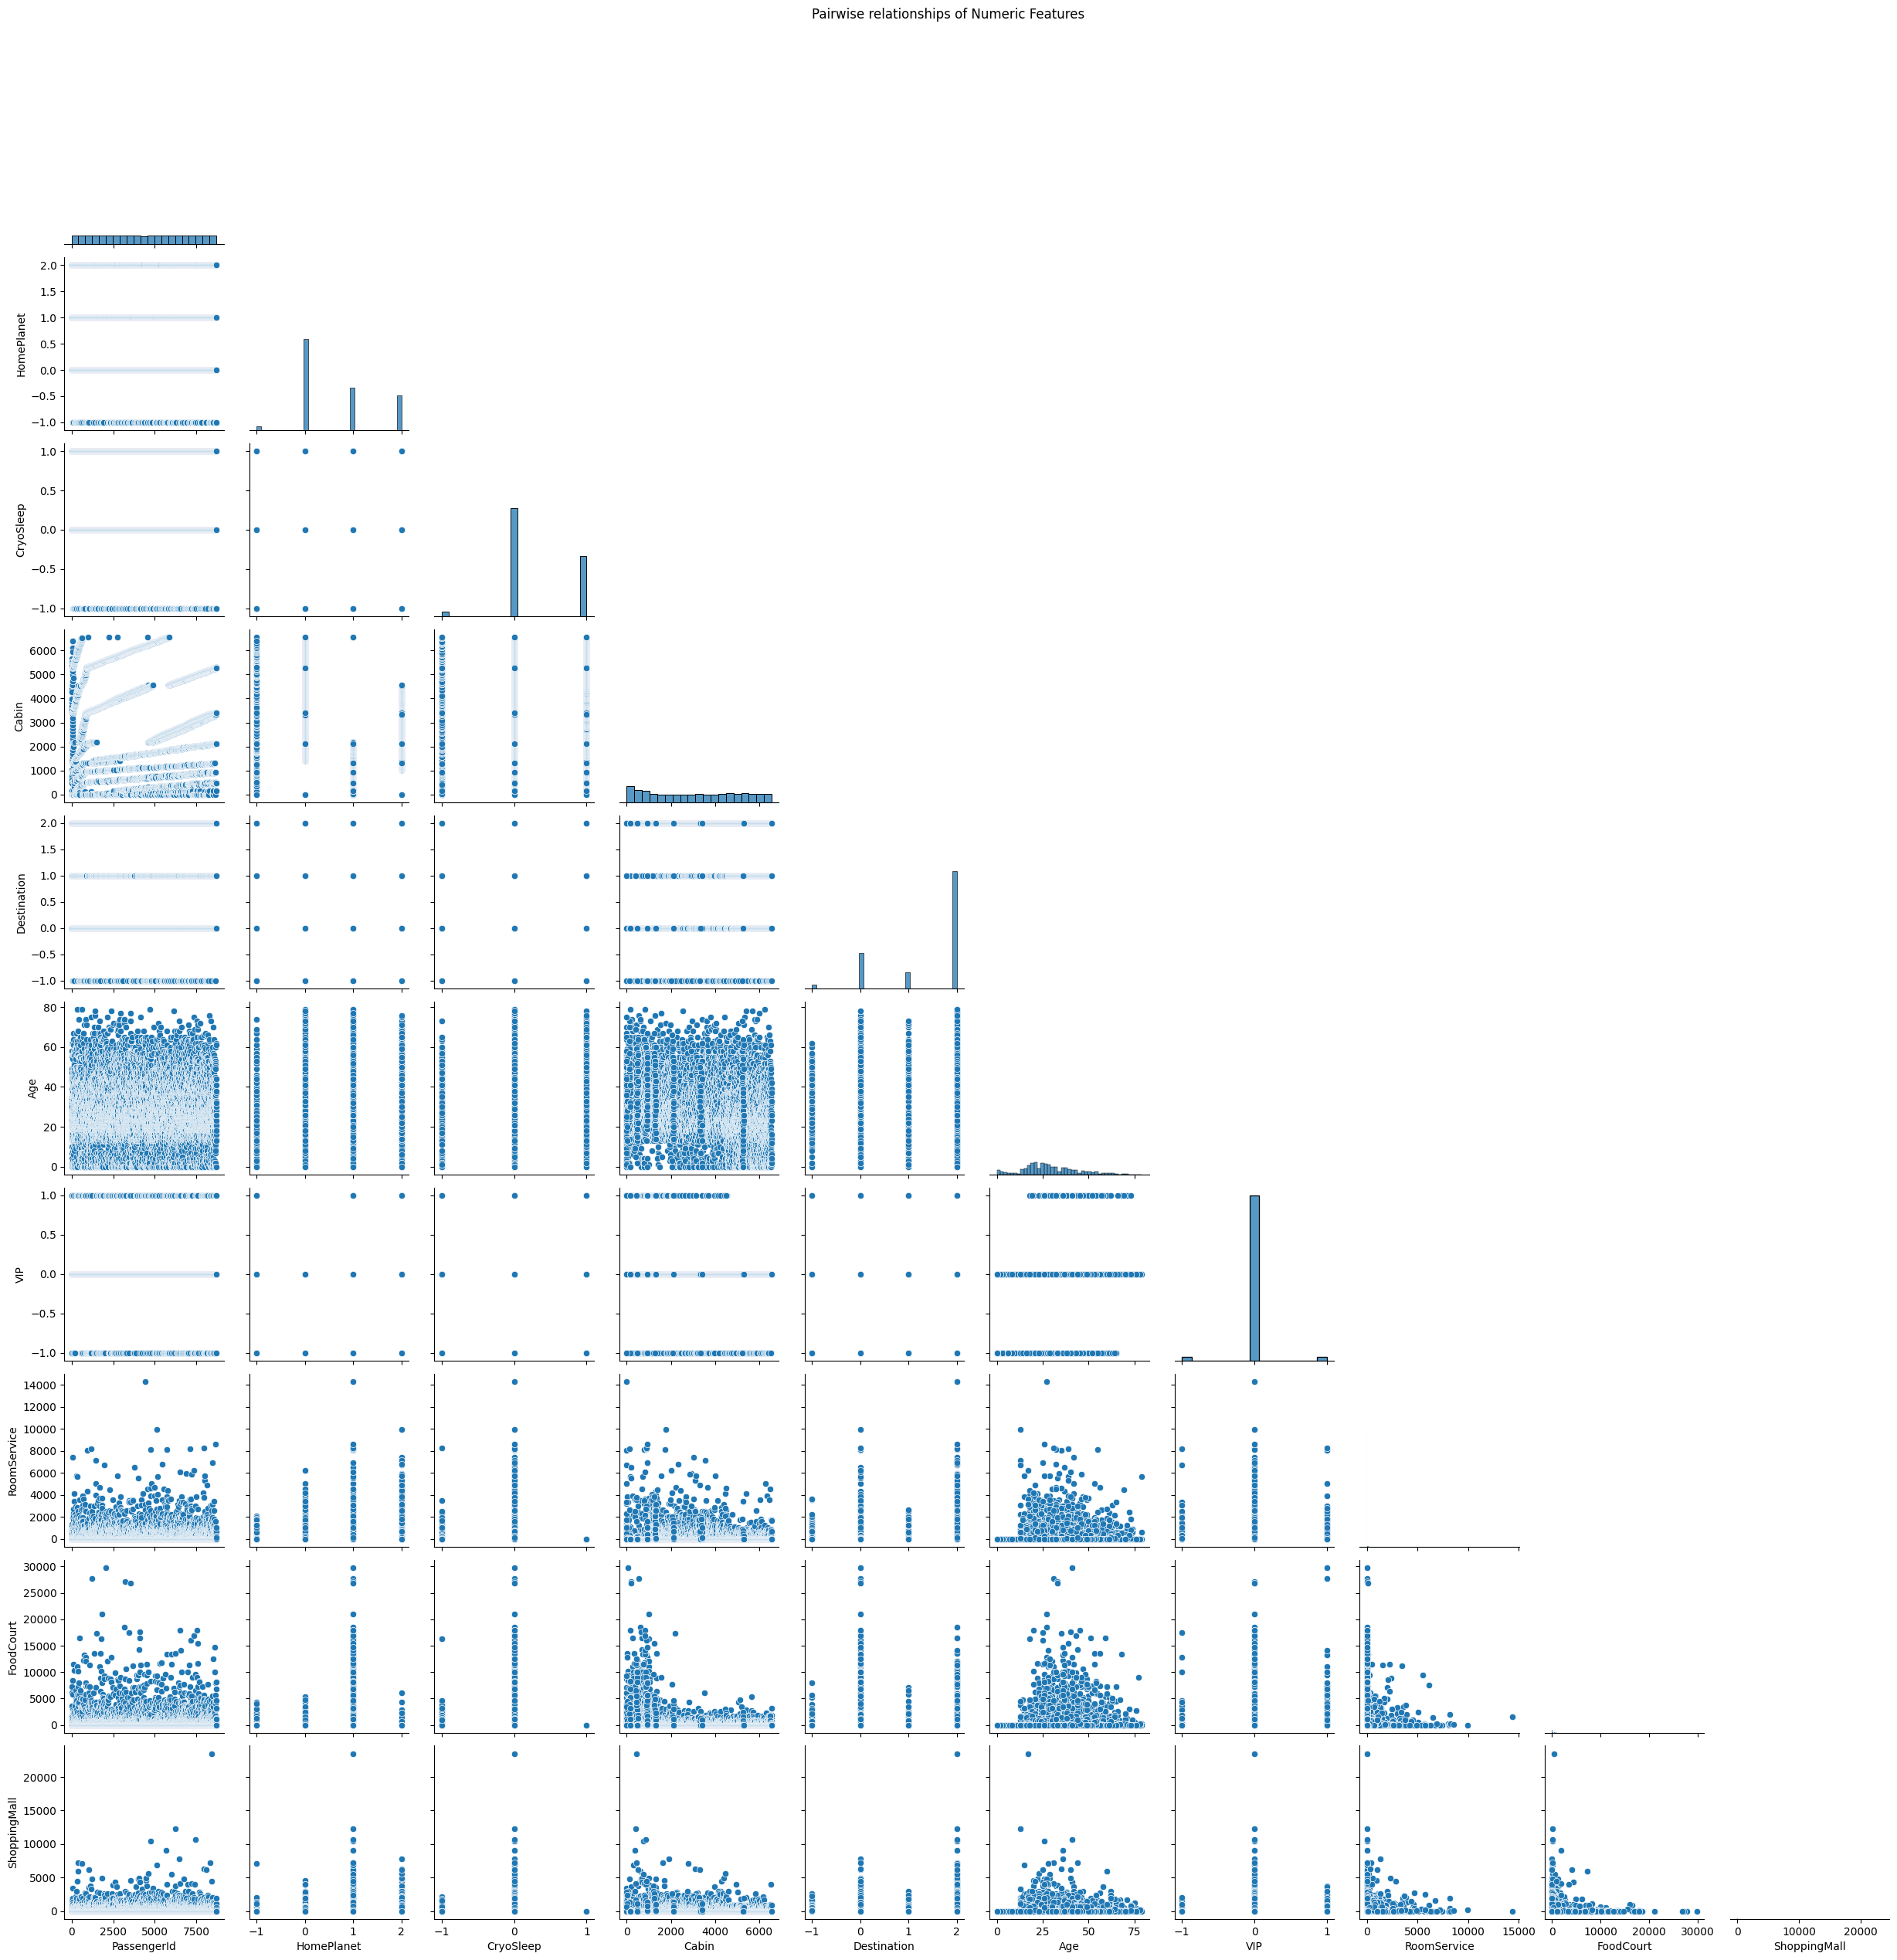

In [874]:
def plot_all_field_relationships(df):
    # Handle categorical data: Convert to numeric codes for correlation analysis (optional)
    # This step is simplistic and may not be meaningful for non-ordinal categories.
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'bool']).columns:
        df_numeric[col] = df_numeric[col].astype('category').cat.codes

    # Pair Plot for numeric fields (considering the whole DataFrame may be too much, so focus on key fields)
    # Selecting a subset of fields if necessary due to the broad scope and to avoid overwhelming plots
    numeric_cols = df_numeric.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 10:  # limiting to first 10 numeric columns to keep the plot readable
        numeric_cols = numeric_cols[:10]
    sns.pairplot(df_numeric[numeric_cols], corner=True)
    plt.suptitle('Pairwise relationships of Numeric Features', y=1.02)
    plt.show()

plot_all_field_relationships(train_df)

Smart Imputation Models

In [875]:
# Categorical
def impute_with_classification_and_evaluate(df, feature_names, target_name):
    # Copy the DataFrame to avoid changing the original data
    df_copy = df.copy()
    df_copy_2 = df.copy()
    df_copy = df_copy[feature_names]
    df_copy[target_name] = df_copy_2[target_name]
    
    # Identify specified categorical features for encoding
    categorical_features = [col for col in feature_names if col in df_copy.select_dtypes(include=['object']).columns]
    
    # Encode specified categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df_copy[categorical_features]).toarray()
    encoded_df = pd.DataFrame(encoded_features, index=df_copy.index, columns=encoder.get_feature_names_out(categorical_features))
    
    # Drop the original categorical columns from df_copy
    df_copy = df_copy.drop(columns=categorical_features)
    
    # Combine the encoded features with the rest of the data
    # Ensure we only add back the encoded columns that were specified in feature_names
    df_copy = pd.concat([df_copy, encoded_df], axis=1)
    
    # Rest of the function remains the same
    # Split the data into rows with known and unknown target values
    known_target = df_copy.dropna(subset=[target_name])
    unknown_target = df_copy[df_copy[target_name].isnull()]
    
    X_known = known_target.drop(columns=[target_name])
    y_known = known_target[target_name]
    
    # Ensure the target variable is appropriate for classification
    # Check and convert y_known to categorical if it's not already
    if not pd.api.types.is_categorical_dtype(y_known):
        y_known = y_known.astype('category')

    # Now check for NaN values in y_known - this should be empty given your current logic
    if y_known.isnull().any():
        raise ValueError("y_known contains NaN values, which is not supported for classification tasks.")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)
    
    # Now we proceed with creating and training the RandomForestClassifier
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    
    y_pred_test = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy on Test Set: {accuracy}")
    
    classifier.fit(X_known, y_known)
    
    X_unknown = unknown_target.drop(columns=[target_name])
    predicted_values = classifier.predict(X_unknown)
    
    # df.loc[df[target_name].isnull(), target_name] = predicted_values

    return df

In [876]:
# Numeric
def impute_with_regression_and_evaluate(df, feature_names, target_name):
    # Copy the DataFrame to avoid changing the original data
    df_copy = df.copy()
    
    # Identify categorical features for encoding
    categorical_features = df_copy[feature_names].select_dtypes(include=['object', 'bool']).columns.tolist()
    
    # Encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df_copy[categorical_features]).toarray()
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
    
    # Combine the encoded features with the rest of the data
    df_copy = pd.concat([df_copy.drop(columns=categorical_features), encoded_df], axis=1)
    
    # Split the data into rows with known and unknown target values
    known_target = df_copy.dropna(subset=[target_name])
    unknown_target = df_copy[df_copy[target_name].isnull()]
    
    # Further split known target data into training and testing sets for model evaluation
    X_known = known_target[encoder.get_feature_names_out(categorical_features)]
    y_known = known_target[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)
    
    # Train the linear regression model on the training set
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict target for the test set and calculate RMSE for evaluation
    y_pred_test = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"RMSE on Test Set: {rmse}")
    
    # Retrain the model on all known data
    model.fit(X_known, y_known)
    
    # Predict target for rows where it's unknown
    X_unknown = unknown_target[encoder.get_feature_names_out(categorical_features)]
    predicted_values = model.predict(X_unknown)
    
    # Fill in the missing values with the predictions
    # df.loc[df[target_name].isnull(), target_name] = predicted_values

    return df

VIP Nans

In [877]:
# checking underaged VIPs
vip_age = all_df.groupby(['Age'])['VIP'].mean()
vip_age.head(20)

Age
0.0          0.0
1.0          0.0
2.0          0.0
3.0          0.0
4.0          0.0
5.0          0.0
6.0          0.0
7.0          0.0
8.0          0.0
9.0          0.0
10.0         0.0
11.0         0.0
12.0         0.0
13.0         0.0
14.0         0.0
15.0         0.0
16.0         0.0
17.0         0.0
18.0     0.00616
19.0    0.002252
Name: VIP, dtype: object

In [878]:
# impute vips based on underaged
impute_columns = ['VIP']
under_aged = (all_df['Age'] < 18)
all_df.loc[under_aged, impute_columns] = all_df.loc[under_aged, impute_columns].fillna(0)

In [879]:
# current missing values
all_df.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             242
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
From_df_1         0
Deck            299
Room_Number     299
Side            299
GroupId           0
dtype: int64

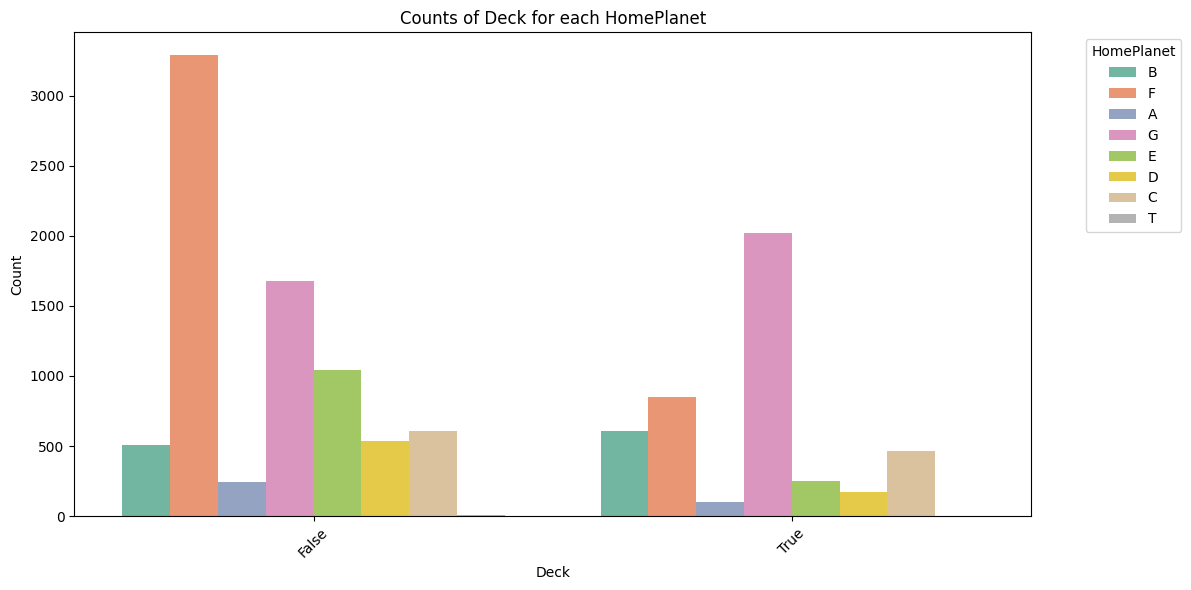

In [880]:
plt.figure(figsize=(12, 6))
sns.countplot(data=all_df, x='CryoSleep', hue='Deck', palette='Set2')
plt.title('Counts of Deck for each HomePlanet')
plt.xlabel('Deck')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels to improve readability if necessary
plt.legend(title='HomePlanet', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels and legend
plt.show()

In [881]:
# VIP classifier
all_df_imputed = impute_with_classification_and_evaluate(all_df, ['HomePlanet'], 'VIP')

Accuracy on Test Set: 0.9807541241162608


Spending Nans

In [882]:
def plot_spending_relationships_categorical(df, category_column, spending_categories):
    # Melt the DataFrame to make it suitable for sns.catplot
    melted_df = df.melt(id_vars=[category_column], value_vars=spending_categories,
                        var_name='SpendingCategory', value_name='AmountSpent')
    
    # Plotting
    sns.catplot(x='SpendingCategory', y='AmountSpent', hue=category_column, kind='bar', data=melted_df, height=6, aspect=2)
    plt.title(f'Spending in Various Categories Based on {category_column} Status')
    plt.xticks(rotation=45)
    plt.show()

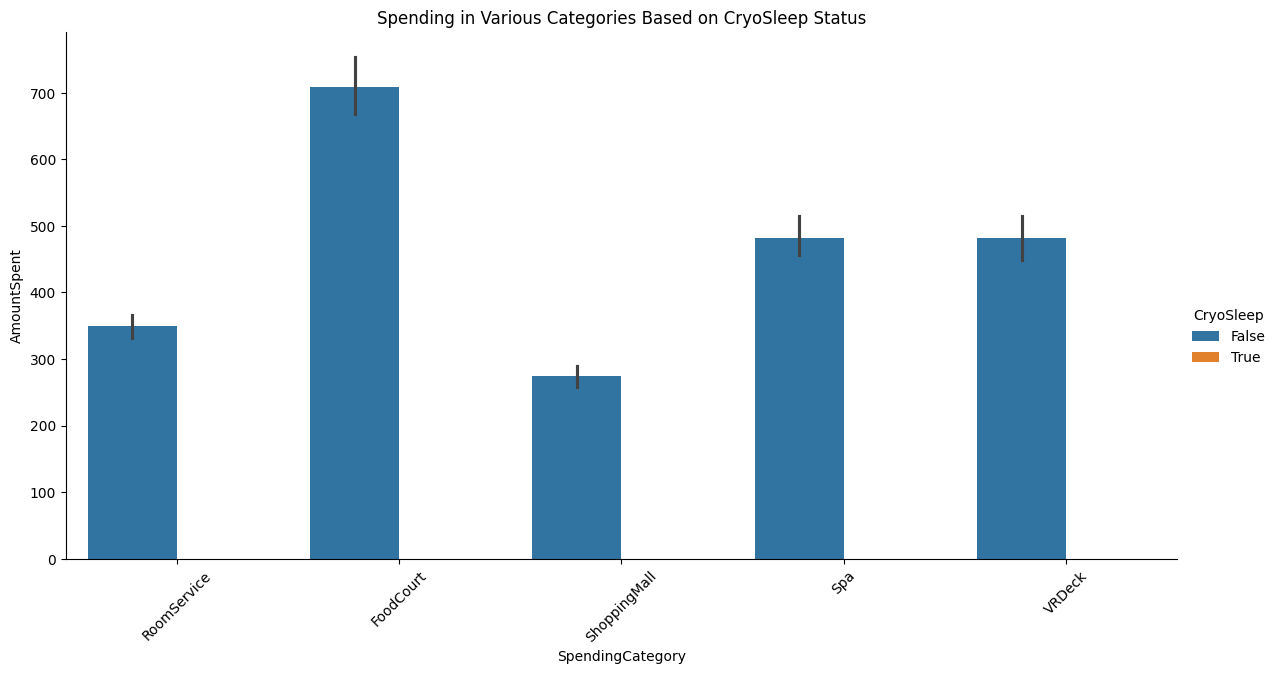

In [883]:
# cryo versus amount spent in all spenidng categories
plot_spending_relationships_categorical(all_df, 'CryoSleep', ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

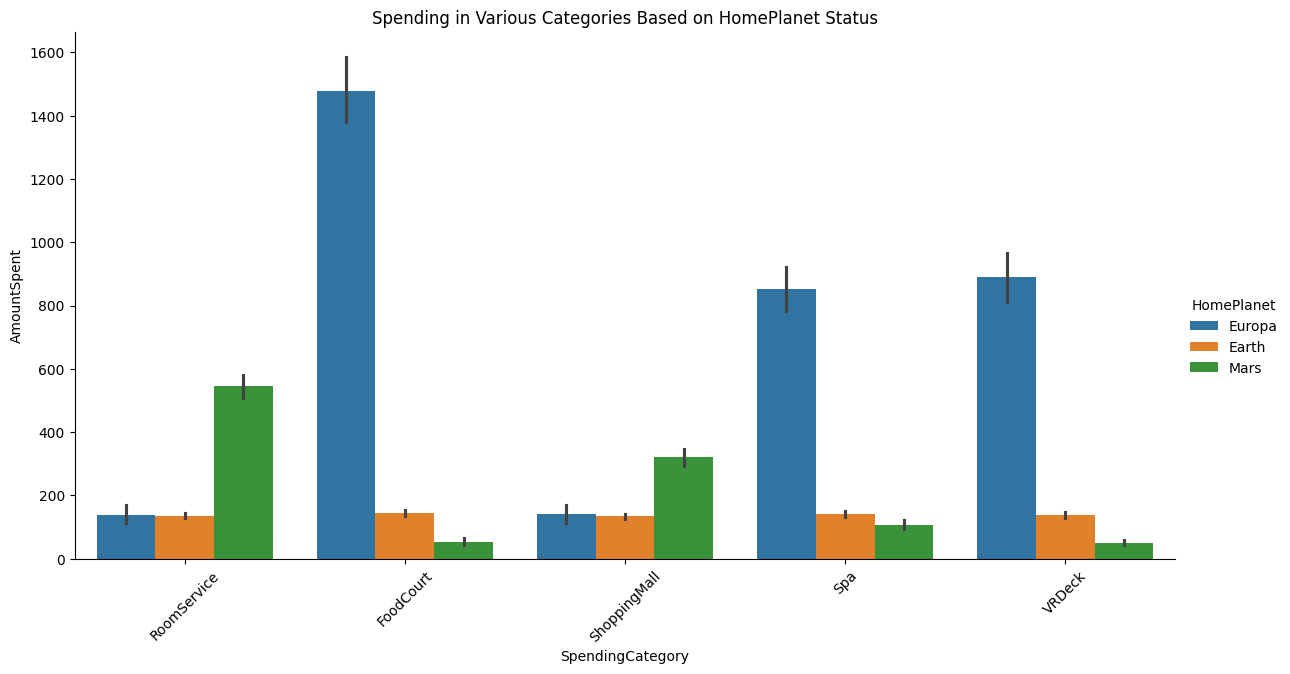

In [884]:
# HomePlanet and spending
plot_spending_relationships_categorical(all_df, 'HomePlanet', ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [885]:
# VIP versus amount spent in all spenidng categories
vip_cryo = all_df.groupby(['CryoSleep'])['VIP'].mean()
print(vip_cryo)

CryoSleep
False    0.030165
True     0.006221
Name: VIP, dtype: object


In [886]:
# Impute nans
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
vip_column = ['VIP']

cryo = (all_df['CryoSleep'] == True)

all_df.loc[cryo, spending_columns] = all_df.loc[cryo, spending_columns].fillna(0)
all_df.loc[cryo, vip_column] = all_df.loc[cryo, vip_column].fillna(0)

In [887]:
# checking age cuttoff for spending
all_copy = all_df.copy()
all_copy['TotalSpend'] = all_copy['RoomService'] + all_copy['FoodCourt'] + all_copy['ShoppingMall'] + all_copy['Spa'] + all_copy['VRDeck']
all_copy.head()
age_spending = all_copy.groupby(['Age'])['TotalSpend'].mean()
age_spending.head(18)

Age
0.0       0.000000
1.0       0.000000
2.0       0.000000
3.0       0.000000
4.0       0.000000
5.0       0.000000
6.0       0.000000
7.0       0.000000
8.0       0.000000
9.0       0.000000
10.0      0.000000
11.0      0.000000
12.0      0.000000
13.0    951.844660
14.0    687.735450
15.0    878.577982
16.0    727.946341
17.0    902.204444
Name: TotalSpend, dtype: float64

In [888]:
# current missing values
all_df.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             162
RoomService     170
FoodCourt       180
ShoppingMall    175
Spa             177
VRDeck          177
Name            294
From_df_1         0
Deck            299
Room_Number     299
Side            299
GroupId           0
dtype: int64

In [889]:
# imputing spending for underaged
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
under_aged = (all_df['Age'] < 13)
all_df.loc[under_aged, spending_columns] = all_df.loc[under_aged, spending_columns].fillna(0)

In [890]:
# current missing values
all_df.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             162
RoomService     162
FoodCourt       171
ShoppingMall    163
Spa             166
VRDeck          150
Name            294
From_df_1         0
Deck            299
Room_Number     299
Side            299
GroupId           0
dtype: int64

In [891]:
# Regression Imputation of RoomSerice
all_df_imputed = impute_with_regression_and_evaluate(all_df, ['Destination', 'HomePlanet', 'Deck', 'VIP'], 'RoomService')

RMSE on Test Set: 632.1130702239983


In [892]:
# current missing values
all_df.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             162
RoomService     162
FoodCourt       171
ShoppingMall    163
Spa             166
VRDeck          150
Name            294
From_df_1         0
Deck            299
Room_Number     299
Side            299
GroupId           0
dtype: int64

# Random Forest

In [893]:
# Custom transformer to convert all data to strings
class ConvertToString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype(str)

In [894]:
new_train_df, new_test_df = get_seperate_dataframes(all_df_imputed)

# Identify categorical and numerical columns
numerical_features = ['Room_Number', 'Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','Deck', 'Side']

# Preprocessing for numerical data: impute missing values with 0
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), # could be mean
    ('scaler', StandardScaler())  # Standardize features by removing the mean and scaling to unit variance
])

# Update the categorical_transformer to include ConvertToString
categorical_transformer = Pipeline(steps=[
    ('convert_to_string', ConvertToString()),  # Convert all data to strings
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # could be changed to most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [895]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(new_train_df, target, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_val_pred = model.predict(X_val)
print("Accuracy on validation set:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report for validation set:\n", classification_report(y_val, y_val_pred))

Accuracy on validation set: 0.7975848188614146

Classification Report for validation set:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80       861
        True       0.82      0.77      0.79       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



# GBM

In [896]:
SEED = 15

# Fit data to preprocessor, and clean the data, rename columns to correct names afterwards
transformed_data_train = preprocessor.fit_transform(train_df)
transformed_data_test = preprocessor.transform(test_df)

feature_names = preprocessor.named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(input_features=categorical_features) 

all_feature_names = numerical_features + list(feature_names)

# Turns data into dataframes
transformed_train_df = pd.DataFrame(transformed_data_train, columns = all_feature_names)
transformed_test_df = pd.DataFrame(transformed_data_test, columns = all_feature_names)

ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# better model overall, performed better on data with less overfitting
#forest_model = RandomForestClassifier(criterion='gini', n_estimators=70, max_depth=5, min_samples_split=2, min_samples_leaf=2,
#                                       max_features='sqrt', random_state=SEED)

# First GBM Model
gbm_model_1 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, loss='exponential', subsample=0.5)

# Second GBM Model
gbm_model_2 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='log_loss')

# Third GBM Model
gbm_model_3 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='exponential')

X_train, X_test, y_train, y_test = train_test_split(transformed_train_df, target, test_size=0.2, random_state=SEED)

In [ ]:
# Fit both models
gbm_model_1.fit(X_train, y_train)
gbm_model_2.fit(X_train, y_train)
gbm_model_3.fit(X_train, y_train)

# Run through predictions initially to train the Logistic Regression for predicting
gbm_1_predictions = gbm_model_1.predict(X_test)
gbm_2_predictions = gbm_model_2.predict(X_test)
gbm_3_predictions = gbm_model_3.predict(X_test)


# Stack both predictions to form a training set for the Logistic Regression
stacked_features = np.column_stack((gbm_1_predictions, gbm_2_predictions, gbm_3_predictions))

# Fit the meta model to stacked features
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Predict yet again to get a new metric
gbm_1_base_preds = gbm_model_1.predict(X_test)
gbm_2_base_preds = gbm_model_2.predict(X_test)
gbm_3_base_preds = gbm_model_3.predict(X_test)


# Stack both predictions yet again
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

# Get final predictions to gauge overall performance
ensemble_predictions = meta_model.predict(stacked_base_preds)

# Score the predictions and print them
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.8039102932719954


In [ ]:
# Get new base predictions for actual test set
gbm_1_base_preds = gbm_model_1.predict(transformed_test_df)
gbm_2_base_preds = gbm_model_2.predict(transformed_test_df)
gbm_3_base_preds = gbm_model_3.predict(transformed_test_df)

# Combine both predictions for the meta model to predict
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

In [ ]:
# Actually predict the final result
ensemble_predictions = meta_model.predict(stacked_base_preds)

In [ ]:
output = pd.DataFrame({
    'PassengerId' : test_ids,
    'Transported' : ensemble_predictions
})
output.to_csv('submission.csv', index=False)
print('Submission Saved')

Submission Saved
